In [3]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.drawOptions.annotationFontScale = 0.8

from magicmethyl.magicmethyl import methylate
from magicmethyl import utils

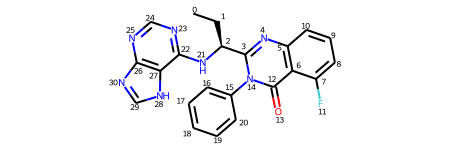

Conformer 0 failed to converge.
Conformer 3 failed to converge.
Conformer 6 failed to converge.
Conformer 8 failed to converge.
Conformer 14 failed to converge.
Conformer 15 failed to converge.


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [5]:
smi = 'CC[C@@H](C1=NC2=C(C(=CC=C2)F)C(=O)N1C3=CC=CC=C3)NC4=NC=NC5=C4NC=N5'
mol = Chem.MolFromSmiles(smi)
display(mol)

mol_mmff = utils.get_low_energy_conformer(mol)
utils.display_3d_mol(mol_mmff)

mol_xtb = utils.xtb_geom_opt(mol_mmff)
utils.display_3d_mol(mol_xtb)

In [8]:
Chem.rdMolAlign.CalcRMS(mol_mmff, mol_xtb)

0.4772782505444216

In [ ]:
def get_low_energy_conformer(input_mol: Chem.rdchem.Mol, 
                             max_iters: int = 200,
                             xtb_refine: bool = False) -> Chem.rdchem.Mol:
    """Obtain the lowest energy conformer.
    
    Finds the MMFF low-energy conformer. It generates n conformers, where n 
    depends on the number of rotatable bonds. Then the conformers are optimized
    with the MMFF forcefield. Finally, the lowest energy conformer is returned.
    Will raise error if the number of rotatable bonds is greater than 10.

    Examples
    --------
    mol = Chem.MolFromSmiles('OCCCO')
    low_e_mol = get_low_energy_conformer(mol)

    Parameters
    ----------
    input_mol: `rdkit.Chem.rdchem.Mol`
        The input RDKit mol object. 
    max_iters: `int`, default = 200
        The number of iterations allowed for the MMFF optimization.

    Returns
    -------
    `rdkit.Chem.rdchem.Mol`
        An RDKit Mol object embedded with the (hopefully) lowest energy
        conformer"""
    # Make a copy of input mol. Second argument indicates a quickCopy, where 
    #  properties and conformers are not copied.
    mol = Chem.rdchem.Mol(input_mol, True)
    mol = Chem.AddHs(mol)
    low_e_mol = Chem.rdchem.Mol(mol, True)

    # Use the number of rotatable bonds to determine the number of conformers to
    #  generate. Raise ValueError if number of rotatable bonds is too high. 
    #  See https://doi.org/10.1021/ci400020a for further details.
    n_rot_bonds = rdMolDescriptors.CalcNumRotatableBonds(mol)
    if n_rot_bonds <= 6:
        rdDistGeom.EmbedMultipleConfs(mol, numConfs=50, pruneRmsThresh=0.5)
    elif n_rot_bonds > 6 and n_rot_bonds <=10:
        rdDistGeom.EmbedMultipleConfs(mol, numConfs=200, pruneRmsThresh=0.5)
    else:
        raise ValueError('Too many rotatable bonds.')

    # Optimize all conformers embeded in mol.
    opt = AllChem.MMFFOptimizeMoleculeConfs(mol, maxIters=max_iters)

    xtb_energies = None
    if xtb_refine:
        xtb_energies = []
        for i in range(len(opt)):
            # TODO get list of xtb energies for conformers 

    # Find the index of lowest energy conformer.
    energy = 1000.0
    index = 0
    for i, o in enumerate(opt):
        # o is a tuple where o[0] = 0 if optimization converged and 1 if not. 
        #  o[1] is the energy of the final structure.
        if o[0] != 0:
            print(f'Conformer {i} failed to converge.')
        else:
            if o[1] < energy:
                energy = o[1]
                index = i

    # Add the lowest energy found conformer to low_e_mol and return it.
    low_e_mol.AddConformer(mol.GetConformer(index))
    return low_e_mol